# Frequency Power Analysis

> Notebook version of `plot_frequency_power_combined.py` that loads EEG/stage files, computes stage-wise power spectra, and writes the combined plot.

In [18]:
# Imports
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from neurodsp.spectral import compute_spectrum

plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 1,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

## Paths and Analysis Parameters
Configure input EEG/stage files, the channel of interest, and the output location. Update these paths if you are working on a different system.

In [19]:
# Update these paths if the dataset lives elsewhere.
DATA_ROOT = Path("/Volumes/harris/somnotate/to_score_set")

EEG_FILES = [
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-007_ses-01_recording-01.pkl",
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-010_ses-01_recording-01.pkl",
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-011_ses-01_recording-01.pkl",
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-015_ses-01_recording-01.pkl",
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-016_ses-02_recording-01.pkl",
    DATA_ROOT / "pickle_eeg_signal" / "eeg_data_sub-017_ses-01_recording-01.pkl",
]

STAGE_FILES = [
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_512Hz.csv",
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_512Hz.csv",
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_512Hz.csv",
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_512Hz_stitched.csv",
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_512Hz.csv",
    DATA_ROOT / "vis_back_to_csv" / "automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_512Hz.csv",
]

CHANNEL = "EEG1"
SAMPLING_RATE = 512

STAGE_MAPPING = {1: "Wake", 2: "NREM", 3: "REM"}
STAGE_LABELS = ["Wake", "NREM", "REM"]
STAGE_COLOR_HEX = ["#E69F00", "#56B4E9", "#CC79A7"]
STAGE_COLORS = dict(zip(STAGE_LABELS, STAGE_COLOR_HEX))

EEG_DATAFRAMES: list[pd.DataFrame] = []
STAGE_DATAFRAMES: list[pd.DataFrame] = []

## Load EEG and Stage Tables
Read the pickle/CSV pairs once so they can be reused for additional exploration later in the notebook.

In [20]:
def load_sleep_data(eeg_files, stage_files, channel):
    """Load paired EEG pickle files and stage annotation CSV files."""
    if len(eeg_files) != len(stage_files):
        raise ValueError("The number of EEG files and stage files must match.")

    eeg_dfs: list[pd.DataFrame] = []
    stage_dfs: list[pd.DataFrame] = []

    for eeg_path, stage_path in zip(eeg_files, stage_files):
        print(f"Loading EEG data from {eeg_path} ...")
        with eeg_path.open("rb") as eeg_handle:
            eeg_df = pickle.load(eeg_handle)

        if channel not in eeg_df.columns:
            raise ValueError(f"Channel '{channel}' not found in {eeg_path.name}.")

        print(f"Loading stage annotations from {stage_path} ...")
        stage_df = pd.read_csv(stage_path)

        if "sleepStage" not in stage_df.columns:
            raise ValueError(f"Column 'sleepStage' missing in {stage_path.name}.")

        if len(eeg_df) != len(stage_df):
            raise ValueError("EEG signal and sleep stage scoring lengths do not match.")

        eeg_dfs.append(eeg_df)
        stage_dfs.append(stage_df)

    return eeg_dfs, stage_dfs


EEG_DATAFRAMES, STAGE_DATAFRAMES = load_sleep_data(EEG_FILES, STAGE_FILES, CHANNEL)

Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-007_ses-01_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_512Hz.csv ...
Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-010_ses-01_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_512Hz.csv ...
Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-011_ses-01_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_512Hz.csv ...
Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-015_ses-01_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_512Hz_stitched.csv ...
Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-016_ses-02_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_512Hz.csv ...
Loading EEG data from /Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-017_ses-01_recording-01.pkl ...


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_25927/2462501350.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  eeg_df = pickle.load(eeg_handle)


Loading stage annotations from /Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_512Hz.csv ...


## Plot Average Stage Spectra
Aggregate each subject's stage-specific spectra, then display the log-power average with a standard-deviation band.

In [16]:
def plot_average_power_spectra(
    eeg_dataframes,
    stage_dataframes,
    channel,
    sampling_rate,
    stage_mapping,
    stage_colors,
    stage_labels=None,
    stage_palette=None,
    linewidth=2.5,
    alpha=0.3,
    freq_limits=(0, 40),
):
    """Plot the average Welch power spectrum for each sleep stage across subjects."""
    if len(eeg_dataframes) != len(stage_dataframes):
        raise ValueError("EEG and stage dataframe counts must match.")

    stage_order = stage_labels if stage_labels is not None else list(stage_mapping.values())
    palette = stage_palette if stage_palette is not None else [stage_colors.get(stage) for stage in stage_order]
    stage_color_map = {stage: color for stage, color in zip(stage_order, palette)}

    all_spectra = {stage: [] for stage in stage_order}
    freqs_subset = None

    freq_low, freq_high = freq_limits

    for eeg_df, stage_df in zip(eeg_dataframes, stage_dataframes):
        eeg_signal = eeg_df[channel].to_numpy()
        sleep_stage_ids = stage_df["sleepStage"].to_numpy()

        if len(eeg_signal) != len(sleep_stage_ids):
            raise ValueError("EEG signal and sleep stage scoring lengths do not match.")

        renamed_stages = np.vectorize(stage_mapping.get)(sleep_stage_ids)

        for stage in stage_order:
            stage_indices = np.flatnonzero(renamed_stages == stage)
            if stage_indices.size == 0:
                continue

            stage_signal = eeg_signal[stage_indices]
            freqs, power = compute_spectrum(
                stage_signal,
                fs=sampling_rate,
                method="welch",
                nperseg=sampling_rate * 2,
            )

            freq_mask = (freqs >= max(0.5, freq_low)) & (freqs <= freq_high)
            freqs_stage = freqs[freq_mask]
            power_stage = power[freq_mask]
            all_spectra[stage].append(power_stage)

            if freqs_subset is None:
                freqs_subset = freqs_stage

    if freqs_subset is None:
        raise RuntimeError("No spectra were computed. Check that each stage is present in the data.")

    fig, ax = plt.subplots(figsize=(10, 6))

    for stage in stage_order:
        stage_powers = all_spectra[stage]
        if not stage_powers:
            print(f"Skipping {stage} because no samples were available.")
            continue

        stage_powers = np.vstack(stage_powers)
        avg_power = np.mean(stage_powers, axis=0)
        std_power = np.std(stage_powers, axis=0)

        lower = np.clip(avg_power - std_power, a_min=1e-20, a_max=None)
        upper = np.clip(avg_power + std_power, a_min=1e-20, a_max=None)

        color = stage_color_map.get(stage, None)

        ax.plot(
            freqs_subset,
            10 * np.log10(avg_power),
            label=stage,
            color=color,
            linewidth=linewidth,
        )
        ax.fill_between(
            freqs_subset,
            10 * np.log10(lower),
            10 * np.log10(upper),
            color=color,
            alpha=alpha,
        )

    ax.set_xlabel("Frequency (Hz)", fontsize=22)
    ax.set_ylabel("10*log(Power)", fontsize=22)
    ax.set_xlim(freq_limits)
    ax.set_xticks(np.arange(freq_limits[0], freq_limits[1] + 1, 5))
    ax.tick_params(axis="x", labelsize=22)
    ax.tick_params(axis="y", labelsize=22)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=20)
    fig.tight_layout()

    return fig, ax

## Run the Pipeline
Execute the loader and plotting functions to materialize the stage-averaged spectrum.

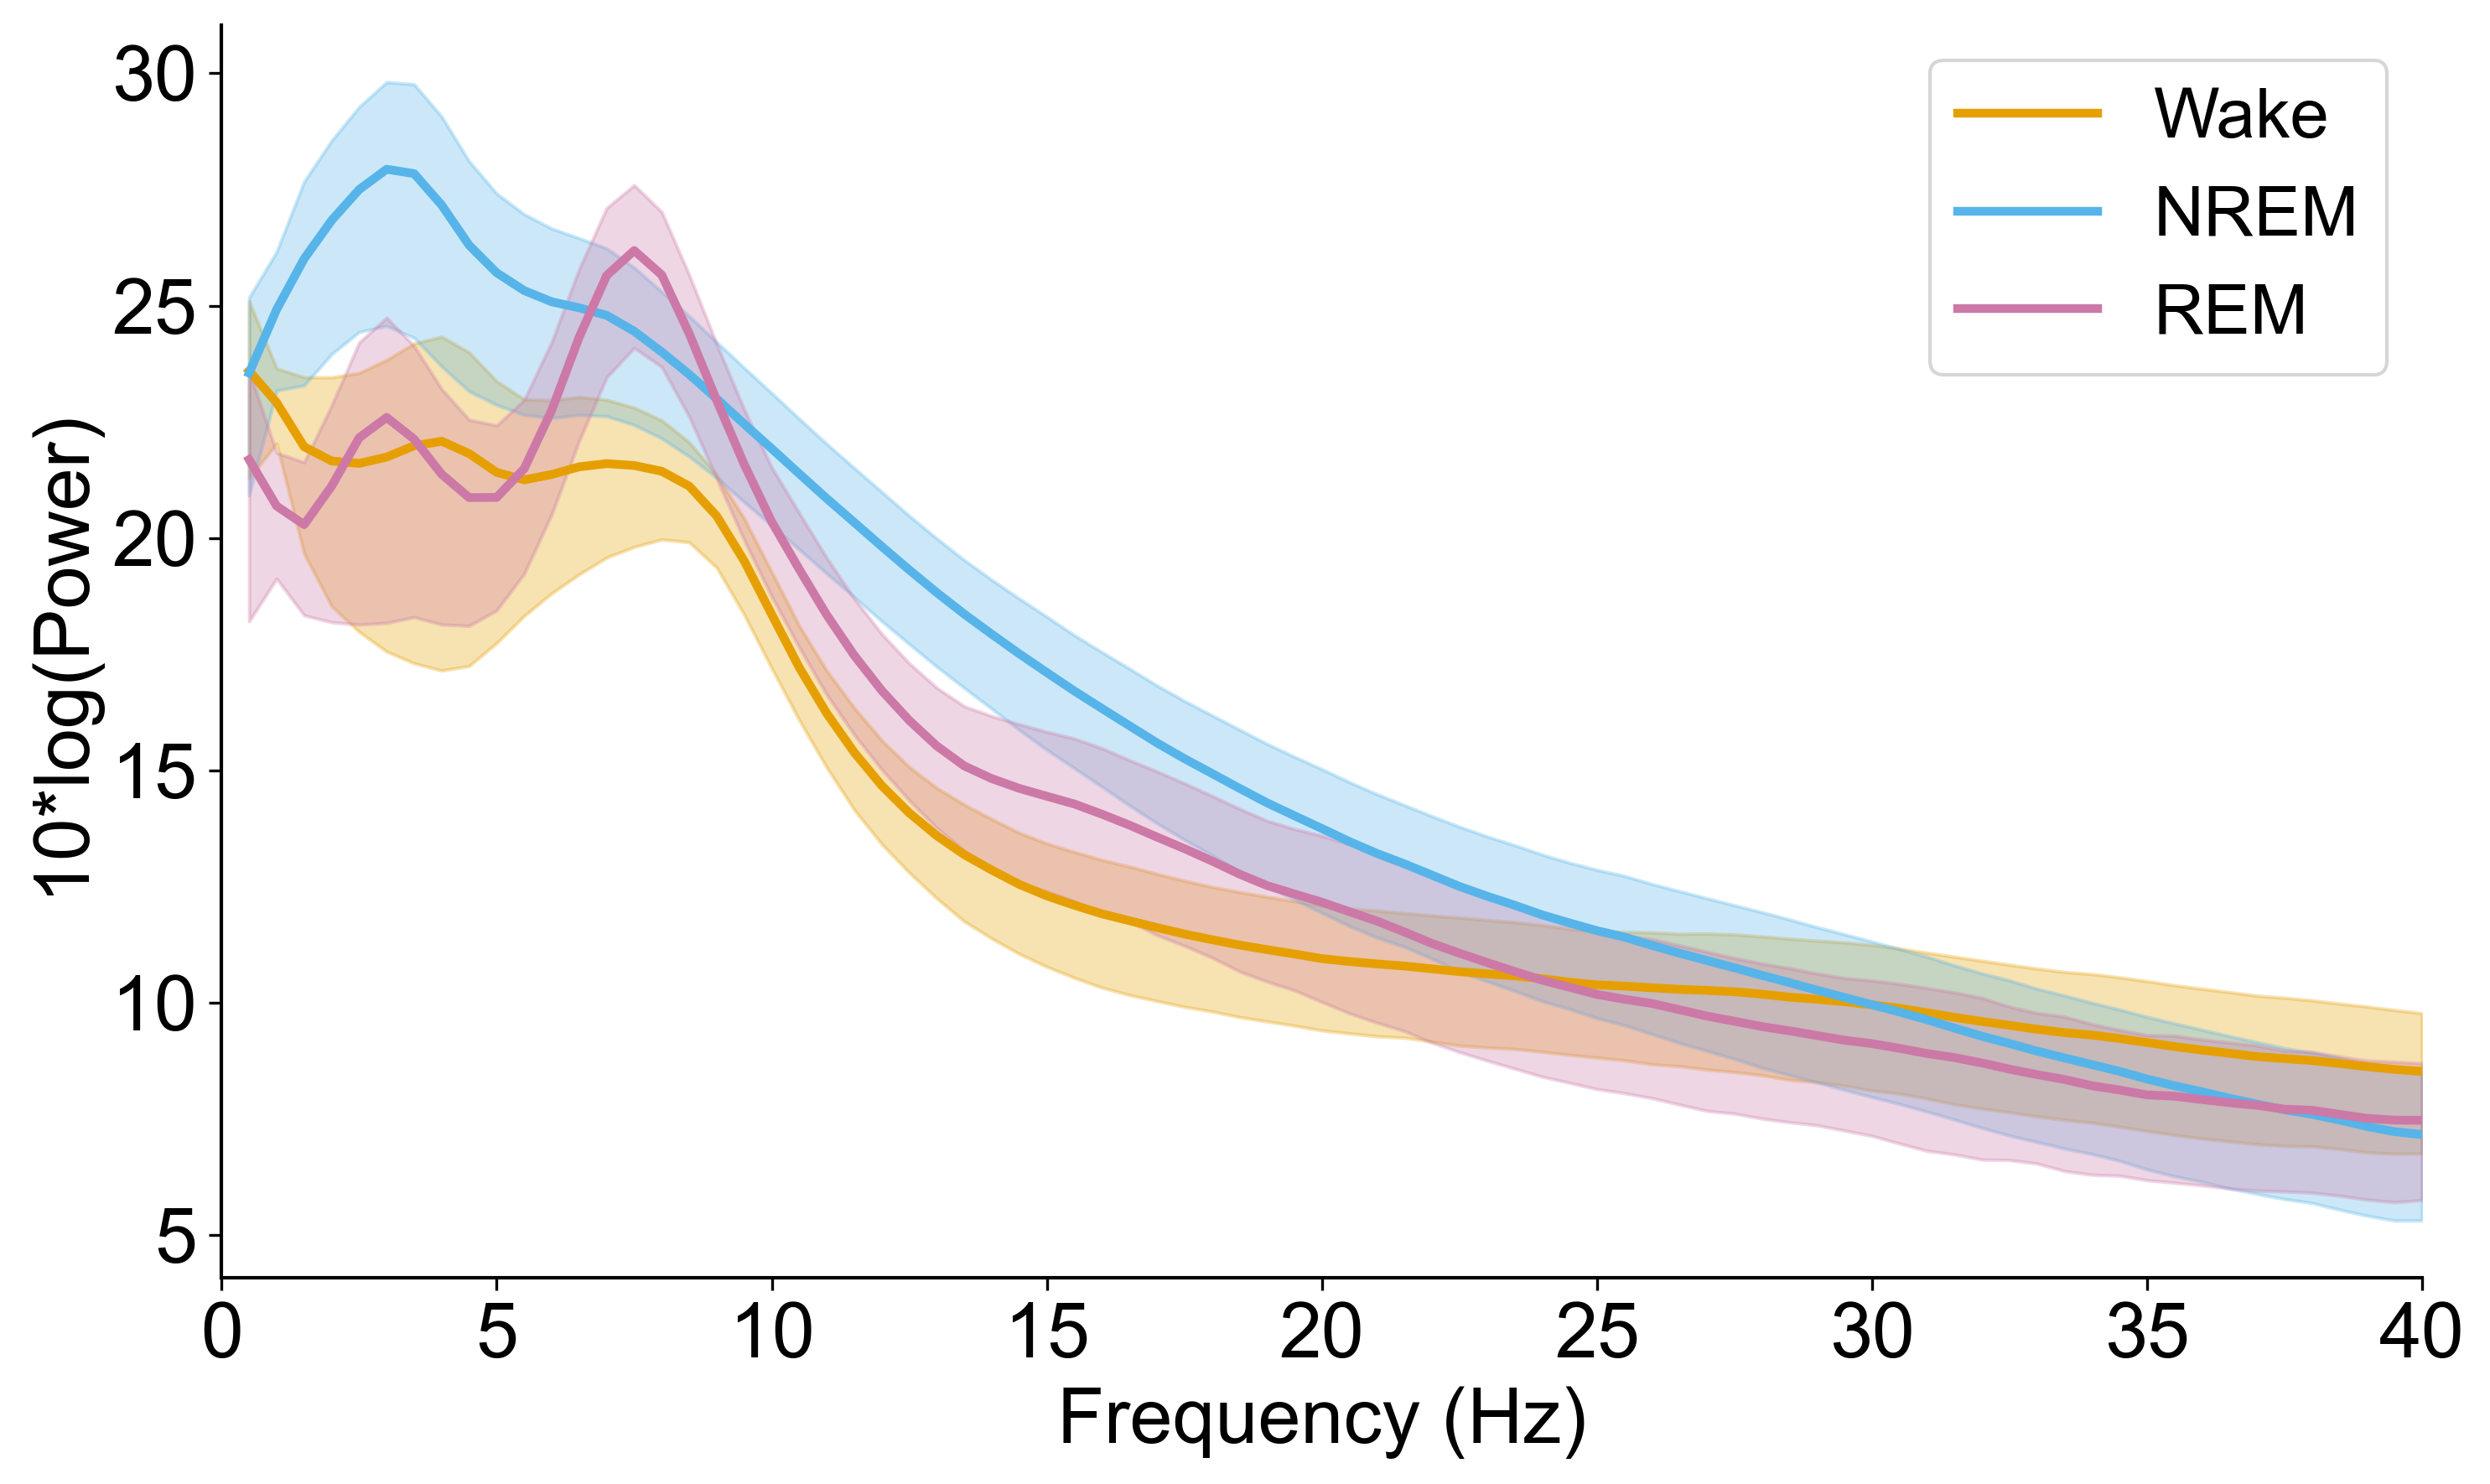

In [21]:
fig, ax = plot_average_power_spectra(
    EEG_DATAFRAMES,
    STAGE_DATAFRAMES,
    channel=CHANNEL,
    sampling_rate=SAMPLING_RATE,
    stage_mapping=STAGE_MAPPING,
    stage_colors=STAGE_COLORS,
    stage_labels=STAGE_LABELS,
    stage_palette=STAGE_COLOR_HEX,
    linewidth=2.5,
    alpha=0.3,
    freq_limits=(0, 40),
)